In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

# model imports
from sklearn.linear_model import SGDRegressor, LinearRegression, RidgeCV, LassoLars, ElasticNetCV
from sklearn.isotonic import IsotonicRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
# feature selection and preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
# cross validation and grid search
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

In [2]:
def numeric_map(iterator):
    """
        Construct a numeric map for a given iterator.
        
        Parameters
        ----------
        iterator: uncertain
            iterator for which numeric map is to be built
        
        Returns
        -------
        list
    """
    num_map = {}
    for idx, val in enumerate(iterator):
        if val in num_map:
            continue
        num_map[val] = idx
    
    return [num_map[x] for x in iterator]

In [3]:
def plot_corr(df, size_x=30, size_y=30):
    """
        Plot seaborn correlation matrix. Dataframe feature slice should be
        conducted prior to invoking this method.
        
        Parameters
        ----------
        df : {pandas.DataFrame}
            values for which correlation is built and plotted
    """
    fig, ax = plt.subplots(figsize=(size_x,size_y))
    corr = df.corr()
    # truncate correlation matrix
    for col in corr.columns:
        corr[col] = corr[col].apply(lambda x: "%.3f" % x)
        corr[col] = corr[col].apply(lambda x: float(x))
    # seaborn plot
    sb.heatmap(corr, annot=True, fmt="g", cmap="viridis")
    plt.show()

In [4]:
def regression_report(y_true, y_pred, estimator=""):
    """
        Helper function for error outputs.
        
        Parameters
        ----------
        y_true : numpy.1darray
            true labels for test data
        
        y_pred : numpy.1darray
            predicted labels for test data
        
        estimator : str
            name of estimator (for output purposes)
    """
    print "%s mean absolute error:  %s"% (estimator, mean_absolute_error(y_true, y_pred))
    print "%s mean squared error: %s" % (estimator, mean_squared_error(y_true, y_pred))

In [5]:
def ohe_transform(df):
    """
        One hot encode dataframe (categorical variables). It is assumed that the
        dataframe has been sliced (i.e. correct categorical features have been selected).
        
        Parameters
        ----------
        df : pandas.DataFrame
            structure to be transformed
    """
    dv = DictVectorizer(sparse=False)
    cat_dict = [dict(row[1]) for row in df.iterrows()]
    return pd.DataFrame(dv.fit_transform(cat_dict), columns=dv.get_feature_names())

In [6]:
def model(estimator, X_train, y_train, X_test, y_test, estimator_name):
    """
        General model method which trains, predicts, and reports.
        
        Parameters
        ----------
        estimator : sklearn.{general}
            scikit-learn estimator with methods: fit, predict ;
            assumes estimators have been passed with optimal params 
        
        X_train : numpy.ndarray
            training set
        
        y_train : numpy.1darray
            training label set
        
        X_test : numpy.ndarray
            test set
        
        y_test : numpy.1darray
            test label set
        
        estimator_name : string
            name for reporting purposes
    """
    print "========== %s ==========" % estimator_name
    print estimator.get_params()
    estimator.fit(X_train, y_train)
    prediction = estimator.predict(X_test)
    regression_report(y_test, prediction, estimator=estimator_name)
    print "\n"

In [7]:
df_train = pd.read_csv("train.csv")

In [8]:
categorical_features = [col for col in df_train.columns if "cat" in col]
continuous_features = [col for col in df_train.columns if "cont" in col]

In [9]:
df_categorical = df_train[["id", "loss"] + categorical_features]

In [10]:
df_continuous = df_train[["id", "loss"] + continuous_features]

In [11]:
# unique identifiers == number of records => we don't have to worry about grouping IDs
len(df_categorical) == len(set(df_categorical.id))

True

In [12]:
df_categorical.head()

,id,loss,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,1,2213.18,A,B,A,B,A,A,A,A,...,J,G,BU,BC,C,AS,S,A,O,LB
1,2,1283.60,A,B,A,A,A,A,A,A,...,K,K,BI,CQ,A,AV,BM,A,O,DP
2,5,3005.09,A,B,A,A,B,A,A,A,...,F,A,AB,DK,A,C,AF,A,I,GK
3,10,939.85,B,B,A,B,A,A,A,A,...,K,K,BI,CS,C,N,AE,A,O,DJ
4,11,2763.85,A,B,A,B,A,A,A,A,...,G,B,H,C,C,Y,BM,A,K,CK


In [14]:
# remove redundant categorical features

In [13]:
# build numeric map for each of the categories and plot correlation
df_categorical_num = df_categorical[["id", "loss"]]

for col in df_categorical.columns:
    if col in ["id", "loss"]:
        continue
    df_categorical_num["%s_num" % df_categorical[col].name] = numeric_map(df_categorical[col])

/Users/cvq595/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [29]:
# plot correlation matrix between sets of features

In [14]:
# group 'single_char' and 'multi' columns
single_char = []

for col in df_categorical.columns:
    if col in ["id", "loss"]:
        continue
    elif all([True if len(item) == 1 else False for item in df_categorical[col]]):
        single_char.append(col)

In [15]:
multi_cols = list(set(df_categorical.columns) - set(single_char))
multi_cols = [col for col in multi_cols if col not in ["id", "loss"]]

In [16]:
df_categorical_num_single = df_categorical_num[["%s_num" % col for col in single_char]]
df_categorical_num_multi = df_categorical_num[["%s_num" % col for col in multi_cols]]

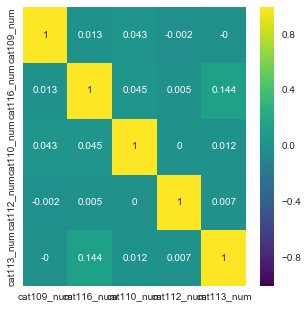

In [17]:
# no strongly correlated multi-char columns
plot_corr(df_categorical_num_multi, size_x=5, size_y=5)

In [37]:
# single character categorical variable correlation
# cat73_num, cat74_num strongly correlated with cat100_num
# cat73_num strongly correlated with cat74_num
# cat6_num strongly correlated with cat50_num
# cat9_num strongly correlated with cat2_num
# not going to discard any of the strongly correlated categorical variables for now

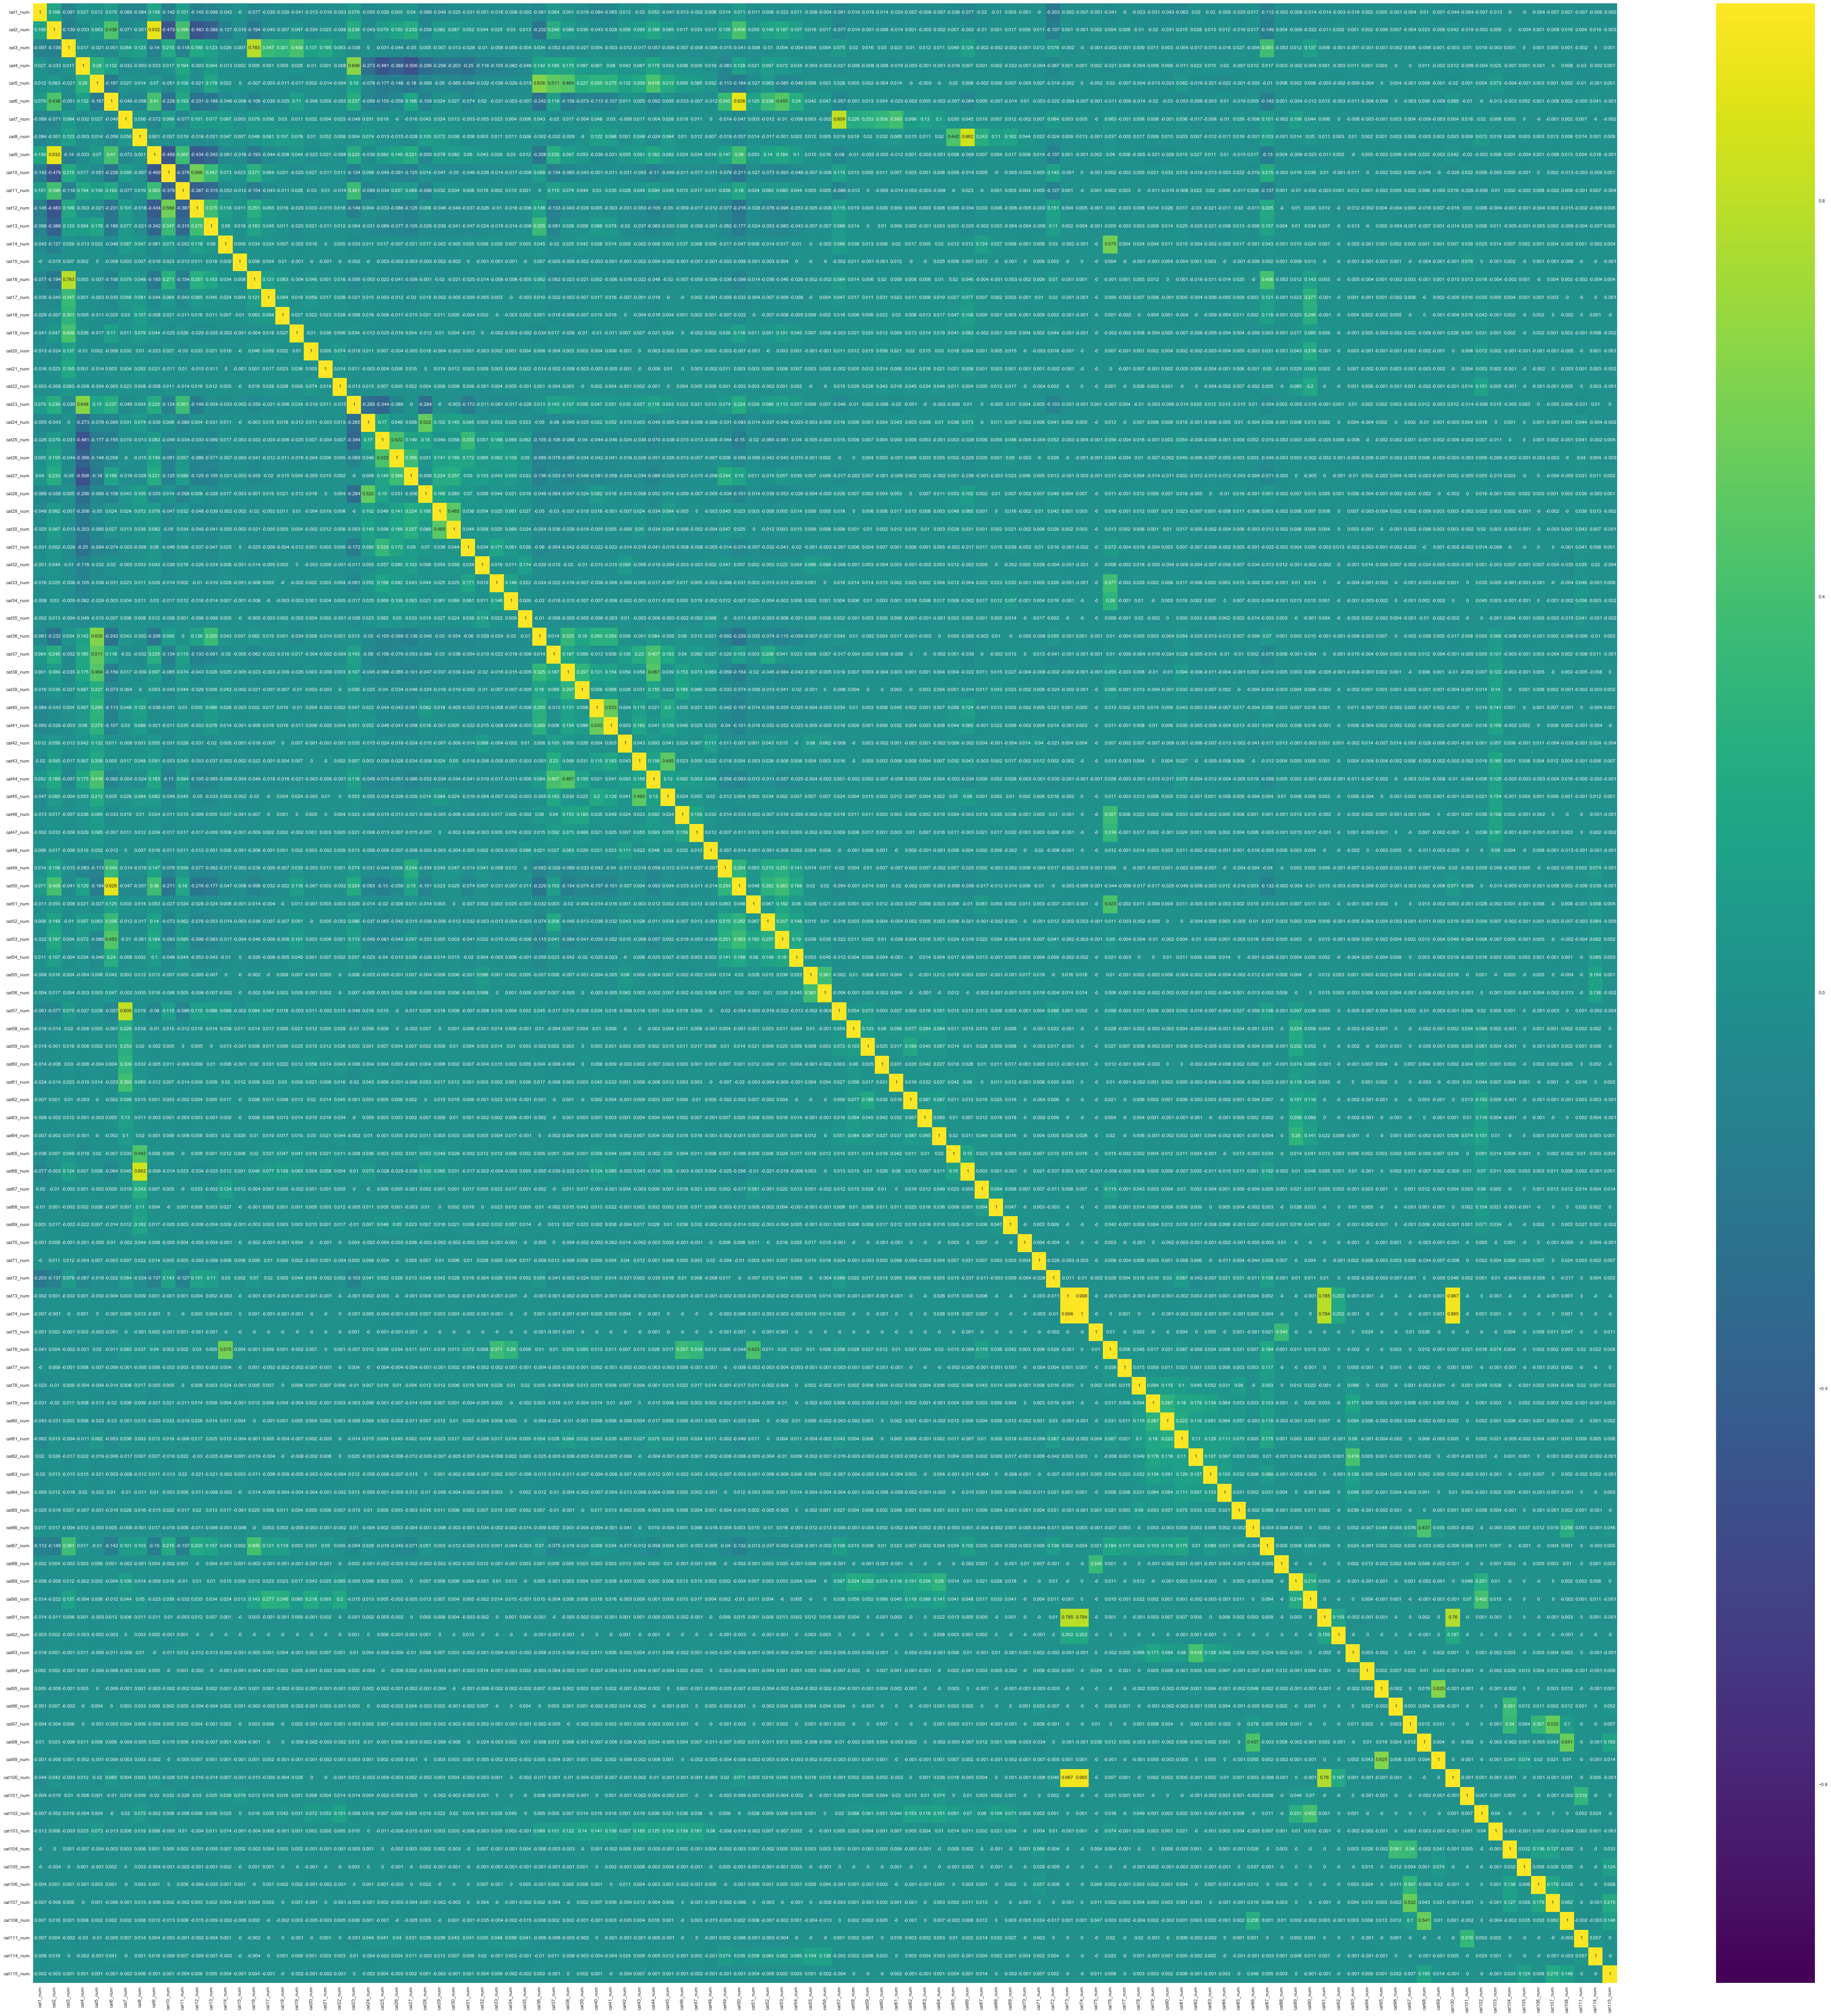

In [18]:
plot_corr(df_categorical_num_single, size_x=75, size_y=75)

In [39]:
# one hot encode categorical variables

In [19]:
features = [col for col in df_categorical.columns if col not in ["id", "loss"]]

In [20]:
# use a dict vectorizer as we need to retrieve feature names
dv = DictVectorizer(sparse=False)

In [21]:
cat_dict = [dict(row[1]) for row in df_categorical[features].iterrows()]

In [22]:
ohe = pd.DataFrame(dv.fit_transform(cat_dict), columns=dv.get_feature_names())

In [23]:
ohe.shape

(188318, 1139)

In [24]:
X_cat = ohe.values

In [25]:
y_cat = df_categorical["loss"].values

In [ ]:
# use different regressors and model selection algorithm for strictly cat features

In [26]:
split = int(0.8*X_cat.shape[0])
X_cat_train = X_cat[:split]
y_cat_train = y_cat[:split]
X_cat_test = X_cat[split:]
y_cat_test = y_cat[split:]

In [27]:
lr_reg = LinearRegression()

In [28]:
lr_reg.fit(X_cat_train, y_cat_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [29]:
loss_predict = lr_reg.predict(X_cat_test)

In [30]:
# compute mean absolute and squared error
print "Linear Regression mean absolute error: %s" % mean_absolute_error(y_cat_test, loss_predict)
print "Linear Regression mean squared error: %s" % mean_squared_error(y_cat_test, loss_predict)

Linear Regression mean absolute error: 283699593900.0
Linear Regression mean squared error: 1.13904159969e+27


In [31]:
lr_sfm = SelectFromModel(lr_reg, prefit=True)

In [32]:
lr_support = lr_sfm.get_support()

In [33]:
lr_feature_selection = ohe.columns[lr_support]

In [34]:
# default parameters for sgd
sgd_reg = SGDRegressor(verbose=2)

In [35]:
sgd_reg.fit(X_cat_train, y_cat_train)

-- Epoch 1
Norm: 4320.13, NNZs: 1122, Bias: 195.153960, T: 150654, Avg. loss: 2278707.489124
Total training time: 0.48 seconds.
-- Epoch 2
Norm: 4948.34, NNZs: 1122, Bias: 210.946737, T: 301308, Avg. loss: 2241795.545410
Total training time: 0.92 seconds.
-- Epoch 3
Norm: 5275.51, NNZs: 1122, Bias: 217.608155, T: 451962, Avg. loss: 2224630.979105
Total training time: 1.35 seconds.
-- Epoch 4
Norm: 5556.14, NNZs: 1122, Bias: 222.634227, T: 602616, Avg. loss: 2213412.376394
Total training time: 1.78 seconds.
-- Epoch 5
Norm: 5778.21, NNZs: 1122, Bias: 232.420007, T: 753270, Avg. loss: 2205385.657833
Total training time: 2.21 seconds.


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=2, warm_start=False)

In [36]:
# prediction and error output
loss_prediction = sgd_reg.predict(X_cat_test)
regression_report(y_cat_test, loss_prediction, estimator="SGD Regressor")

SGD Regressor mean absolute error:  1318.12251185
SGD Regressor mean squared error: 4146285.44085


In [37]:
sgd_sfm = SelectFromModel(sgd_reg, prefit=True)
sgd_feature_selection = ohe.columns[sgd_sfm.get_support()]
print len(sgd_feature_selection)

377


In [38]:
# linear svm - regression
lsvr_reg = LinearSVR(verbose=2) # default params => consider lowering C for greater regularization
lsvr_reg.fit(X_cat_train, y_cat_train)
loss_prediction = lsvr_reg.predict(X_cat_test)
regression_report(y_cat_test, loss_prediction, estimator="Linear SVR")
lsvr_sfm = SelectFromModel(lsvr_reg, prefit=True)
lsvr_feature_selection = ohe.columns[lsvr_sfm.get_support()]
print len(lsvr_feature_selection)

[LibLinear]Linear SVR mean absolute error:  1239.71445401
Linear SVR mean squared error: 4545297.97456
316


In [39]:
# ridge with cross validation; default params => consider increasing alpha (C^-1)
rcv_reg = RidgeCV()
rcv_reg.fit(X_cat_train, y_cat_train)
loss_prediction = rcv_reg.predict(X_cat_test)
regression_report(y_cat_test, loss_prediction, estimator="RidgeCV")
rcv_sfm = SelectFromModel(rcv_reg, prefit=True)
rcv_feature_selection = ohe.columns[rcv_sfm.get_support()]
print len(rcv_feature_selection)

RidgeCV mean absolute error:  1296.06397858
RidgeCV mean squared error: 4098802.77408
239


In [40]:
# lars lasso; default params
ll_reg = LassoLars()
ll_reg.fit(X_cat_train, y_cat_train)
loss_prediction = ll_reg.predict(X_cat_test)
regression_report(y_cat_test, loss_prediction, estimator="Lasso Lars")
ll_sfm = SelectFromModel(ll_reg, prefit=True)
ll_feature_selection = ohe.columns[ll_sfm.get_support()]
print len(ll_feature_selection)
# strictly 8 features selected

Lasso Lars mean absolute error:  1551.74307047
Lasso Lars mean squared error: 5574987.55179
8


/Users/cvq595/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.366e+00, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/cvq595/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.108e+00, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)


In [ ]:
# lowest mean absolute error with linear svm
# lowest mean squared error with SGD
# mean absolute error is evaluation metric for competition

In [ ]:
# combine features of best performing regressor

In [43]:
categorical_features = list(sgd_feature_selection) + list(lsvr_feature_selection)

In [44]:
categorical_features = list(set(categorical_features))

In [45]:
# create structure of individual features
cat_ft_struct = {}
for feature in categorical_features:
    ft, val = feature.split("=")
    if ft not in cat_ft_struct:
        cat_ft_struct[ft] = []
    cat_ft_struct[ft].append(val)

In [ ]:
# we use the newly created structure to filter out noise (irrelevant categorical values)

In [46]:
df_categorical.head()

,id,loss,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,1,2213.18,A,B,A,B,A,A,A,A,...,J,G,BU,BC,C,AS,S,A,O,LB
1,2,1283.60,A,B,A,A,A,A,A,A,...,K,K,BI,CQ,A,AV,BM,A,O,DP
2,5,3005.09,A,B,A,A,B,A,A,A,...,F,A,AB,DK,A,C,AF,A,I,GK
3,10,939.85,B,B,A,B,A,A,A,A,...,K,K,BI,CS,C,N,AE,A,O,DJ
4,11,2763.85,A,B,A,B,A,A,A,A,...,G,B,H,C,C,Y,BM,A,K,CK


In [47]:
df_categorical_transform = df_categorical.copy()

In [48]:
# apply transformation to categorical features with newly created structure
for col, arr in cat_ft_struct.iteritems():
    if col not in df_categorical_transform.columns:
        continue
    df_categorical_transform[col] = df_categorical_transform[col].apply(lambda x: x if x in arr else "NOISE")

In [49]:
df_categorical_transform.head()

,id,loss,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,1,2213.18,A,B,NOISE,B,A,NOISE,A,NOISE,...,NOISE,G,NOISE,BC,C,AS,S,NOISE,O,NOISE
1,2,1283.60,A,B,NOISE,NOISE,A,NOISE,A,NOISE,...,K,K,BI,NOISE,NOISE,AV,NOISE,NOISE,O,DP
2,5,3005.09,A,B,NOISE,NOISE,B,NOISE,A,NOISE,...,F,A,NOISE,NOISE,NOISE,C,NOISE,NOISE,I,NOISE
3,10,939.85,NOISE,B,NOISE,B,A,NOISE,A,NOISE,...,K,K,BI,CS,C,NOISE,AE,NOISE,O,DJ
4,11,2763.85,A,B,NOISE,B,A,NOISE,A,NOISE,...,NOISE,B,NOISE,NOISE,C,Y,NOISE,NOISE,NOISE,NOISE


In [50]:
cat_features = [col for col in df_categorical_transform.columns if col not in ["id", "loss"]]

In [51]:
cat_ohe = ohe_transform(df_categorical_transform[cat_features])

In [52]:
cat_ohe["df_index"] = cat_ohe.index
df_categorical_transform["df_index"] = range(0, len(df_categorical_transform))
df_categorical_transform = df_categorical_transform[["id", "df_index"]].merge(cat_ohe, on="df_index", how="inner")
df_categorical_transform.drop("df_index", axis=1, inplace=True)

In [53]:
df_categorical_transform.head()

,id,cat100=A,cat100=B,cat100=C,cat100=D,cat100=F,cat100=G,cat100=H,cat100=I,cat100=J,...,cat98=A,cat98=C,cat98=NOISE,cat99=C,cat99=N,cat99=NOISE,cat99=P,cat99=T,cat9=B,cat9=NOISE
0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,11,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


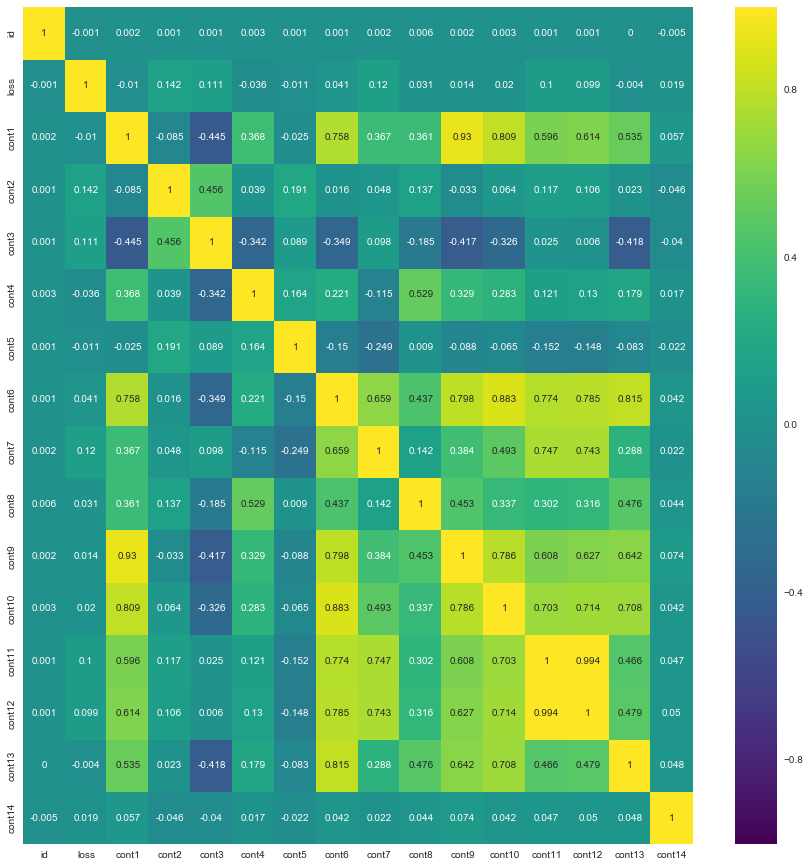

In [54]:
# check correlation of continuous variables
plot_corr(df_continuous, size_x=15, size_y=15)

In [ ]:
# continuous correlation analysis
# cont11 and cont12 - strong correlation (0.994)
# cont9 and cont1 - strong correlation (0.93)
# strong correlation between cont6 and [cont7 - cont13]
# don't see redundant features, so we keep all three

In [ ]:
# noise in OHE categorical can be discarded (corresponds to unimportant feature values)
# use noise now in the hope that models will see non-noise features as being more important predictors

In [55]:
# combine categorical and continuous variables
df_combined = df_continuous.merge(df_categorical_transform, on="id", how="inner")

In [56]:
df_combined.head()

,id,loss,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,...,cat98=A,cat98=C,cat98=NOISE,cat99=C,cat99=N,cat99=NOISE,cat99=P,cat99=T,cat9=B,cat9=NOISE
0,1,2213.18,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,2,1283.60,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,5,3005.09,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,10,939.85,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,11,2763.85,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [57]:
combined_features = [col for col in df_combined.columns if col not in ["id", "loss"]]

In [58]:
X_combined = df_combined[combined_features]
y_combined = df_combined["loss"]
split = int(0.8*len(df_combined))
X_combined_train = X_combined[:split]
y_combined_train = y_combined[:split]
X_combined_test = X_combined[split:]
y_combined_test = y_combined[split:]

In [59]:
# some default parameters for a set of features
# note: scaling not done during preprocessing for continuous - centered assumption 
regressors = {
    "SGD Regressor": SGDRegressor(verbose=2, learning_rate="optimal"), # squared loss (ordinary least squares)
    "Linear SV Regressor": LinearSVR(verbose=2, C=1.0), # l1 regularization
    "RidgeCV": RidgeCV(),
    "Elasticnet CV": ElasticNetCV(),
#     "Kernel Ridge Regressor": KernelRidge(alpha=1.0), => kills python kernel
#     "Polynomial SVR": SVR(kernel="poly"), => kills kernel
    "Lasso LARs Regressor": LassoLars(verbose=2, alpha=0.1),
    "Extra Trees Regressor": ExtraTreesRegressor(n_estimators=100),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100),
    "Ada Boost Regressor": AdaBoostRegressor(n_estimators=100),
    "Gradient Boost Regressor": GradientBoostingRegressor(n_estimators=100)
}

In [62]:
# go through each regressor one at a time => don't have the computational power for some of these models
model(SGDRegressor(verbose=2, learning_rate="optimal"), X_combined_train, y_combined_train, X_combined_test,
      y_combined_test, "SGD Regressor")

========== SGD Regressor ==========
{'warm_start': False, 'loss': 'squared_loss', 'eta0': 0.01, 'verbose': 2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'average': False, 'n_iter': 5, 'penalty': 'l2', 'power_t': 0.25, 'random_state': None, 'epsilon': 0.1, 'alpha': 0.0001, 'learning_rate': 'optimal'}
-- Epoch 1
Norm: 8334426422608.42, NNZs: 530, Bias: -3195637581912.611328, T: 150654, Avg. loss: 1644889696302511008771997696.000000
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 3666288303984.54, NNZs: 530, Bias: -3100698606622.173828, T: 301308, Avg. loss: 824635309406259348154351616.000000
Total training time: 0.41 seconds.
-- Epoch 3
Norm: 2130830497181.08, NNZs: 530, Bias: -3080554908121.243164, T: 451962, Avg. loss: 550116392318913171146407936.000000
Total training time: 0.63 seconds.
-- Epoch 4
Norm: 969379462195.38, NNZs: 530, Bias: -3048387659791.502441, T: 602616, Avg. loss: 412664685148137341438656512.000000
Total training time: 0.83 seconds.
-- Epoch 5
Norm:

In [73]:
model(LinearSVR(verbose=2, C=1.0), X_combined_train, y_combined_train, X_combined_test, y_combined_test,
      "Linear SV Regressor")

========== Linear SV Regressor ==========
{'loss': 'epsilon_insensitive', 'C': 1.0, 'intercept_scaling': 1.0, 'fit_intercept': True, 'epsilon': 0.0, 'max_iter': 1000, 'random_state': None, 'dual': True, 'tol': 0.0001, 'verbose': 2}
[LibLinear]Linear SV Regressor mean absolute error:  1237.02654326
Linear SV Regressor mean squared error: 4502953.49221




In [64]:
model(RidgeCV(), X_combined_train, y_combined_train, X_combined_test, y_combined_test, "RidgeCV")

========== RidgeCV ==========
{'normalize': False, 'alphas': (0.1, 1.0, 10.0), 'fit_intercept': True, 'gcv_mode': None, 'store_cv_values': False, 'scoring': None, 'cv': None}
RidgeCV mean absolute error:  1298.17545452
RidgeCV mean squared error: 4054870.78491




In [65]:
model(ElasticNetCV(verbose=2), X_combined_train, y_combined_train, X_combined_test, y_combined_test, 
      "ElasticNetCV")

========== ElasticNetCV ==========
{'normalize': False, 'alphas': None, 'n_jobs': 1, 'verbose': 2, 'fit_intercept': True, 'selection': 'cyclic', 'l1_ratio': 0.5, 'n_alphas': 100, 'max_iter': 1000, 'eps': 0.001, 'precompute': 'auto', 'random_state': None, 'tol': 0.0001, 'positive': False, 'copy_X': True, 'cv': None}
Path: 000 out of 100
Path: 001 out of 100
Path: 002 out of 100
Path: 003 out of 100
Path: 004 out of 100
Path: 005 out of 100
Path: 006 out of 100
Path: 007 out of 100
Path: 008 out of 100
Path: 009 out of 100
Path: 010 out of 100
Path: 011 out of 100
Path: 012 out of 100
Path: 013 out of 100
Path: 014 out of 100
Path: 015 out of 100
Path: 016 out of 100
Path: 017 out of 100
Path: 018 out of 100
Path: 019 out of 100
Path: 020 out of 100
Path: 021 out of 100
Path: 022 out of 100
Path: 023 out of 100
Path: 024 out of 100
Path: 025 out of 100
Path: 026 out of 100
Path: 027 out of 100
Path: 028 out of 100
Path: 029 out of 100
Path: 030 out of 100
Path: 031 out of 100
Path: 032 o

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.3s finished


ElasticNetCV mean absolute error:  1464.357464
ElasticNetCV mean squared error: 5186655.46575




In [68]:
model(DecisionTreeRegressor(), X_combined_train, y_combined_train, X_combined_test, y_combined_test, 
      "Decision Tree Regressor")

========== Decision Tree Regressor ==========
{'presort': False, 'splitter': 'best', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'max_features': None, 'max_depth': None}
Decision Tree Regressor mean absolute error:  1729.99277984
Decision Tree Regressor mean squared error: 7670718.57966




In [69]:
model(ExtraTreeRegressor(), X_combined_train, y_combined_train, X_combined_test, y_combined_test, 
      "Extra Tree Regressor")

========== Extra Tree Regressor ==========
{'splitter': 'random', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'max_features': 'auto', 'max_depth': None}
Extra Tree Regressor mean absolute error:  1712.08375345
Extra Tree Regressor mean squared error: 7448026.13153




In [71]:
model(LassoLars(verbose=2), X_combined_train, y_combined_train, X_combined_test, y_combined_test,
      "Lasso LARs Regressor")

========== Lasso LARs Regressor ==========
{'normalize': True, 'fit_path': True, 'fit_intercept': True, 'positive': False, 'max_iter': 500, 'eps': 2.2204460492503131e-16, 'precompute': 'auto', 'copy_X': True, 'alpha': 1.0, 'verbose': 2}
.Lasso LARs Regressor mean absolute error:  1549.31821509
Lasso LARs Regressor mean squared error: 5555132.77532




In [ ]:
model(SVR(kernel="poly", verbose=True), X_combined_train, y_combined_train, X_combined_test, y_combined_test,
      "Poly SVR")

========== Poly SVR ==========
{'kernel': 'poly', 'C': 1.0, 'verbose': False, 'degree': 3, 'epsilon': 0.1, 'shrinking': True, 'max_iter': -1, 'tol': 0.001, 'cache_size': 200, 'coef0': 0.0, 'gamma': 'auto'}


In [60]:
for reg_name, reg in regressors.iteritems():
    model(reg, X_combined_train, y_combined_train, X_combined_test, y_combined_test, reg_name)

========== RidgeCV ==========
{'normalize': False, 'alphas': (0.1, 1.0, 10.0), 'fit_intercept': True, 'gcv_mode': None, 'store_cv_values': False, 'scoring': None, 'cv': None}
RidgeCV mean absolute error:  1298.32763397
RidgeCV mean squared error: 4056819.04109


========== SGD Regressor ==========
{'warm_start': False, 'loss': 'squared_loss', 'eta0': 0.01, 'verbose': 2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'average': False, 'n_iter': 5, 'penalty': 'l2', 'power_t': 0.25, 'random_state': None, 'epsilon': 0.1, 'alpha': 0.0001, 'learning_rate': 'optimal'}
-- Epoch 1
Norm: 8579358231330.08, NNZs: 532, Bias: 988692739448.226562, T: 150654, Avg. loss: 1685678144631071920866983936.000000
Total training time: 0.21 seconds.
-- Epoch 2
Norm: 3686357408618.76, NNZs: 532, Bias: 1001833907600.564453, T: 301308, Avg. loss: 845032087909275336515256320.000000
Total training time: 0.44 seconds.
-- Epoch 3
Norm: 2068535631393.62, NNZs: 532, Bias: 996995419168.728271, T: 451962, Avg. 

/Users/cvq595/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=9.379e-01, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/cvq595/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=9.379e-01, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/Users/cvq595/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=6.781e-01, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/cvq

Lasso LARs Regressor mean absolute error:  1406.91253175
Lasso LARs Regressor mean squared error: 4768077.1841


========== Elasticnet CV ==========
{'normalize': False, 'alphas': None, 'n_jobs': 1, 'verbose': 0, 'fit_intercept': True, 'selection': 'cyclic', 'l1_ratio': 0.5, 'n_alphas': 100, 'max_iter': 1000, 'eps': 0.001, 'precompute': 'auto', 'random_state': None, 'tol': 0.0001, 'positive': False, 'copy_X': True, 'cv': None}
Elasticnet CV mean absolute error:  1465.1094749
Elasticnet CV mean squared error: 5189465.42734


========== Ada Boost Regressor ==========
{'n_estimators': 100, 'loss': 'linear', 'base_estimator': None, 'random_state': None, 'learning_rate': 1.0}
Ada Boost Regressor mean absolute error:  7860.36032076
Ada Boost Regressor mean squared error: 66266680.0641


========== Random Forest Regressor ==========
{'warm_start': False, 'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 100, 'min_s